In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import pickle
from fair_loss import FairLoss
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
# from torchmetrics.classification import BinaryFairness
# from fairlearn.metrics import demographic_parity_ratio,  demographic_parity_difference
from sklearn.metrics import f1_score, balanced_accuracy_score,recall_score
import matplotlib.pyplot as plt
# from datasets import ADULT, German, Lawschool, HealthHeritage
# from defenses import dp_defense

In [2]:
import torch
print(torch.__version__)

1.7.1


In [3]:
class LinReLU(nn.Module):

    """
    A linear layer followed by a ReLU activation layer.
    """    
        
    def __init__(self, in_size, out_size):
        super(LinReLU, self).__init__()      
        linear = nn.Linear(in_size, out_size)
        ReLU = nn.ReLU()
        # self.Dropout = nn.Dropout(0.25)
        self.layers = nn.Sequential(linear, ReLU)

    def reset_parameters(self):
        self.layers[0].reset_parameters()
        return self

    def forward(self, x):
        x = self.layers(x)
        return x

class FullyConnected(nn.Module):
    """
    A simple fully connected neural network with ReLU activations.
    """
    def __init__(self, input_size, layout):

        super(FullyConnected, self).__init__()
        layers = [nn.Flatten()]  # does not play any role, but makes the code neater
        prev_fc_size = input_size
        for i, fc_size in enumerate(layout):
            if i + 1 < len(layout):
                layers += [LinReLU(prev_fc_size, fc_size)]
            else:
                layers += [nn.Linear(prev_fc_size, 1), nn.Sigmoid()]
                # layers += [nn.Linear(prev_fc_size, fc_size)]
            prev_fc_size = fc_size
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

In [4]:
client_data_dir='50_clients_data_testing/client_subG_processed/'

layout = [100, 100, 2]
batch_size = 32
num_epochs = 5  
input_dim = 10

model = FullyConnected(input_dim, layout)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01) 

/root/anaconda3/envs/myenv_torch2/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
client_models = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
               "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
               "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
               "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
               "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# client_models = ["AL", "AK"]

# testing_data=["WM","WW","BM","BW"]
# testing_data=["male","female","white","black"]

# Normal Testing

In [7]:
# 0 male
# 1 female
# 1 white
# 2 black

In [9]:
#  tensor(1.0448) convert to 1 ------Female
#  tensor(-0.9571) convert to 0----Male

In [6]:
exp_1="tableak_FT_inversion_normal"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_1}/50_clients_data/clients_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.4945311620485273 : 0.7490521912176983 : 0.7530447709989136 : 0.748971523120505 : 0.7592747398460696
WW
Total length of WW test data: 61620
0.514490643425275 : 0.7175754625121714 : 0.7632792415359712 : 0.7408681938210608 : 0.674382270935487
BM
Total length of BM test data: 6750
0.5307904053920818 : 0.701925925925926 : 0.7549926936190939 : 0.7338011377184317 : 0.6546990496304118
BW
Total length of BW test data: 7730
0.5495355801641448 : 0.6782664941785252 : 0.7472817803068794 : 0.7302605627425715 : 0.6288695057294339
model_name AK
WM
Total length of WM test data: 68843
0.4881939931416046 : 0.7507807620237351 : 0.730874809806905 : 0.7514059283006788 : 0.6715574644720532
WW
Total length of WW test data: 61620
0.5653000102607632 : 0.6748296007789679 : 0.7038969099587699 : 0.7300424226525903 : 0.5724449572156524
BM
Total length of BM test data: 6750
0.594200958714101 : 0.6638518518518518 : 0.705362939877938 : 0.7247656829323894 : 0.57360

In [7]:
final_result

{'AL': {'WM': 0.7592747398460696,
  'WW': 0.674382270935487,
  'BM': 0.6546990496304118,
  'BW': 0.6288695057294339},
 'AK': {'WM': 0.6715574644720532,
  'WW': 0.5724449572156524,
  'BM': 0.5736008447729672,
  'BW': 0.5450658457328544},
 'AZ': {'WM': 0.735925744429391,
  'WW': 0.6455388904912989,
  'BM': 0.6316789862724392,
  'BW': 0.6054386865059005},
 'AR': {'WM': 0.7802600098008129,
  'WW': 0.6987308912604557,
  'BM': 0.6760295670538543,
  'BW': 0.6514451855652471},
 'CA': {'WM': 0.6850479951572453,
  'WW': 0.5862417075281223,
  'BM': 0.5828933474128828,
  'BW': 0.5568667692833932},
 'CO': {'WM': 0.6934939897956243,
  'WW': 0.5963128545332179,
  'BM': 0.5917634635691658,
  'BW': 0.5671284419360356},
 'CT': {'WM': 0.6676371393156727,
  'WW': 0.5673252571868089,
  'BM': 0.5687434002111933,
  'BW': 0.5407901487942535},
 'DE': {'WM': 0.7177654146608631,
  'WW': 0.6239544274588982,
  'BM': 0.6126715945089757,
  'BW': 0.590217205404481},
 'FL': {'WM': 0.7444293909083047,
  'WW': 0.6553456

In [8]:

# filename = "inversion_group_normal_fairness.pickle"
filename = "inversion_subgroup_normal_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_normal_fairness.pickle


# Dp testing

In [9]:
exp_2="tableak_FT_inversion_DP"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_2}/50_clients_data/client_DP_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.49508628606463895 : 0.7490231396075128 : 0.7535446324137733 : 0.7489254094133166 : 0.761407857945865
WW
Total length of WW test data: 61620
0.5142946221313497 : 0.7183868873742292 : 0.764247965546755 : 0.7412098587642721 : 0.6760648014613979
BM
Total length of BM test data: 6750
0.5302447214793254 : 0.7031111111111111 : 0.7564414195430238 : 0.7340757413380637 : 0.6572333685322069
BW
Total length of BW test data: 7730
0.548858838263622 : 0.6816300129366106 : 0.7502790461694572 : 0.7335640438547086 : 0.6322900632803147
model_name AK
WM
Total length of WM test data: 68843
0.48896333560015187 : 0.7501997298200253 : 0.7289548757230444 : 0.7508594360515596 : 0.6665994061860425
WW
Total length of WW test data: 61620
0.5684414328397992 : 0.6727685816293412 : 0.7006709815331632 : 0.7296697398354752 : 0.5672531487356985
BM
Total length of BM test data: 6750
0.5978574238682245 : 0.6610370370370371 : 0.7016949152542374 : 0.7236146011565843 : 0

In [10]:
final_result

{'AL': {'WM': 0.761407857945865,
  'WW': 0.6760648014613979,
  'BM': 0.6572333685322069,
  'BW': 0.6322900632803147},
 'AK': {'WM': 0.6665994061860425,
  'WW': 0.5672531487356985,
  'BM': 0.5683210137275607,
  'BW': 0.5404480930391654},
 'AZ': {'WM': 0.7352915741835058,
  'WW': 0.6446495529276031,
  'BM': 0.629778247096093,
  'BW': 0.6038994356080041},
 'AR': {'WM': 0.7832002536680983,
  'WW': 0.7035621574848572,
  'BM': 0.6775079197465681,
  'BW': 0.6574311612792886},
 'CA': {'WM': 0.6865757689314231,
  'WW': 0.5871550812421883,
  'BM': 0.581414994720169,
  'BW': 0.5578929365486575},
 'CO': {'WM': 0.6926868640281341,
  'WW': 0.5942938179021248,
  'BM': 0.5921858500527983,
  'BW': 0.5661022746707713},
 'CT': {'WM': 0.6686172206047678,
  'WW': 0.5686712816075378,
  'BM': 0.5697993664202745,
  'BW': 0.5419873439370617},
 'DE': {'WM': 0.7164105964082903,
  'WW': 0.6224882222863186,
  'BM': 0.6105596620908131,
  'BW': 0.5886779545065846},
 'FL': {'WM': 0.7479749791012078,
  'WW': 0.6589750

In [11]:

# filename = "inversion_group_dp_fairness.pickle"
filename = "inversion_subgroup_dp_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_dp_fairness.pickle


# Fair testing

In [12]:
exp_3="tableak_FT_inversion_fair"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_3}/50_clients_data/clients_fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.4963935411857185 : 0.7488778815565853 : 0.7538654289700732 : 0.748765129379461 : 0.7631662390821827
WW
Total length of WW test data: 61620
0.5145466420973572 : 0.7207887049659202 : 0.7666327568667344 : 0.7431829630036957 : 0.6792616094606287
BM
Total length of BM test data: 6750
0.5312604182421878 : 0.7007407407407408 : 0.7533577533577535 : 0.7339541611095244 : 0.6515311510031679
BW
Total length of BW test data: 7730
0.5482595575249885 : 0.6799482535575679 : 0.7485772357723578 : 0.7326323824346832 : 0.6298956729946982
model_name AK
WM
Total length of WM test data: 68843
0.4914760577412786 : 0.748950510582049 : 0.7248061398340844 : 0.7496833858557266 : 0.6560779452884034
WW
Total length of WW test data: 61620
0.5720014572607766 : 0.6669263226225252 : 0.6929383602633155 : 0.7264061119146218 : 0.5566291702720892
BM
Total length of BM test data: 6750
0.5992967816890699 : 0.6551111111111111 : 0.6937647987371746 : 0.7213863290369746 : 0.

In [13]:
final_result

{'AL': {'WM': 0.7631662390821827,
  'WW': 0.6792616094606287,
  'BM': 0.6515311510031679,
  'BW': 0.6298956729946982},
 'AK': {'WM': 0.6560779452884034,
  'WW': 0.5566291702720892,
  'BM': 0.5569165786694826,
  'BW': 0.5315546434068753},
 'AZ': {'WM': 0.7318901155919403,
  'WW': 0.639722142101721,
  'BM': 0.6204857444561774,
  'BW': 0.5979134598939627},
 'AR': {'WM': 0.7498486639185956,
  'WW': 0.6643351600807614,
  'BM': 0.6378035902851109,
  'BW': 0.616555498546263},
 'CA': {'WM': 0.6579228041855236,
  'WW': 0.5591289299105855,
  'BM': 0.5592397043294615,
  'BW': 0.5310415597742432},
 'CO': {'WM': 0.6666570580265775,
  'WW': 0.5666762811268148,
  'BM': 0.5708553326293558,
  'BW': 0.5443817342226783},
 'CT': {'WM': 0.628808624715344,
  'WW': 0.5266320546101336,
  'BM': 0.5332629355860612,
  'BW': 0.5012827090815803},
 'DE': {'WM': 0.7393848548614914,
  'WW': 0.6485193731371983,
  'BM': 0.6325237592397043,
  'BW': 0.6080041046690611},
 'FL': {'WM': 0.7363004813928685,
  'WW': 0.6463801

In [14]:

# filename = "inversion_group_fair_fairness.pickle"
filename = "inversion_subgroup_fair_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_fair_fairness.pickle


# fairDP testing

In [15]:
exp_4="tableak_FT_inversion_fairDP"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_4}/50_clients_data/clients_DP_Fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.4943298275225889 : 0.7498511104977993 : 0.7521337996747125 : 0.7498249706529646 : 0.7531636447493586
WW
Total length of WW test data: 61620
0.5176416679303841 : 0.7162447257383966 : 0.7604761709064507 : 0.7427084147507492 : 0.66717142582444
BM
Total length of BM test data: 6750
0.5358416181040037 : 0.6968888888888889 : 0.7487721021611002 : 0.7326340723349954 : 0.6439281942977825
BW
Total length of BW test data: 7730
0.5550004038190054 : 0.6746442432082794 : 0.7428688273182701 : 0.7307464890011273 : 0.6213442791174961
model_name AK
WM
Total length of WM test data: 68843
0.4900265472030551 : 0.7505192975320657 : 0.7315525406774097 : 0.7511185160999652 : 0.6745841861001413
WW
Total length of WW test data: 61620
0.5627136232635066 : 0.6766309639727361 : 0.7060888547996932 : 0.7312727334717171 : 0.575305259109701
BM
Total length of BM test data: 6750
0.5898245133777366 : 0.6617777777777778 : 0.7033138401559454 : 0.7227171608920426 : 0.5

In [16]:
final_result

{'AL': {'WM': 0.7531636447493586,
  'WW': 0.66717142582444,
  'BM': 0.6439281942977825,
  'BW': 0.6213442791174961},
 'AK': {'WM': 0.6745841861001413,
  'WW': 0.575305259109701,
  'BM': 0.5714889123548047,
  'BW': 0.5455789293654866},
 'AZ': {'WM': 0.7214551324551036,
  'WW': 0.6274396692625709,
  'BM': 0.614572333685322,
  'BW': 0.5924405678125535},
 'AR': {'WM': 0.7679513418465884,
  'WW': 0.6850062493990963,
  'BM': 0.6614572333685322,
  'BW': 0.6384470668719001},
 'CA': {'WM': 0.6806088034360497,
  'WW': 0.5816748389577925,
  'BM': 0.5763463569165787,
  'BW': 0.5515649050795279},
 'CO': {'WM': 0.7001816032976853,
  'WW': 0.6023940005768676,
  'BM': 0.5955649419218585,
  'BW': 0.5712331109970925},
 'CT': {'WM': 0.6695973018938629,
  'WW': 0.5704259205845592,
  'BM': 0.5657866948257656,
  'BW': 0.5395929536514452},
 'DE': {'WM': 0.7288345680435848,
  'WW': 0.6371743101624844,
  'BM': 0.6228088701161563,
  'BW': 0.5984265435265949},
 'FL': {'WM': 0.7430745726557321,
  'WW': 0.65414383

In [17]:

# filename = "inversion_group_fairDp_fairness.pickle"
filename = "inversion_subgroup_fairDp_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_fairDp_fairness.pickle


In [18]:
subgrp_exp = True
group_exp = False

In [19]:
if subgrp_exp is True:
    print("Subgrp exp is selected")
    
    normal_train = "inversion_subgroup_normal_fairness.pickle"
    dp_train = "inversion_subgroup_dp_fairness.pickle"
    fair_train = "inversion_subgroup_fair_fairness.pickle"
    fairDP_train = "inversion_subgroup_fairDp_fairness.pickle"
    
if group_exp is True :
    print("group exp is selected")
    
    normal_train = "inversion_group_normal_fairness.pickle"
    dp_train = "inversion_group_dp_fairness.pickle"
    fair_train = "inversion_group_fair_fairness.pickle"
    fairDP_train = "inversion_group_fairDp_fairness.pickle"



with open(normal_train, 'rb') as file:
    normal_train_loaded = pickle.load(file)
with open(dp_train, 'rb') as file:
    dp_train_loaded = pickle.load(file)
with open(fair_train, 'rb') as file:
    fair_train_loaded = pickle.load(file)
with open(fairDP_train, 'rb') as file:
    fairDP_train_loaded = pickle.load(file)




Subgrp exp is selected


In [45]:
def subgroup_calculate_state_ratios(data):
    state_names = []
    ratios_list = []
    denominator_list = []
    
    for state, values in data.items():
        # Find maximum value and its key
        max_value = max(values, key=values.get)
        max_value_amount = values[max_value]
        
        # Calculate ratios
        ratios = {}
        for key, value in values.items():
            if key != max_value:  # Exclude the max_value itself
                ratios[key + '/' + max_value] = value / max_value_amount
        
        # Append state data
        state_names.append(state)
        denominator_list.append(max_value)
        ratios_list.append(ratios)
    
    # Create DataFrame with ratios
    df_final = pd.DataFrame(ratios_list).fillna("")
    
    # Add state column
    df_final.insert(0, 'State', state_names)
    
    # Reset index to make sure it's numeric
    df_final = df_final.reset_index(drop=True)
    
    return df_final

In [46]:
normal_train_df=subgroup_calculate_state_ratios(normal_train_loaded)
dp_train_df=subgroup_calculate_state_ratios(dp_train_loaded)
fair_train_df=subgroup_calculate_state_ratios(fair_train_loaded)
fairDP_train_df=subgroup_calculate_state_ratios(fairDP_train_loaded)

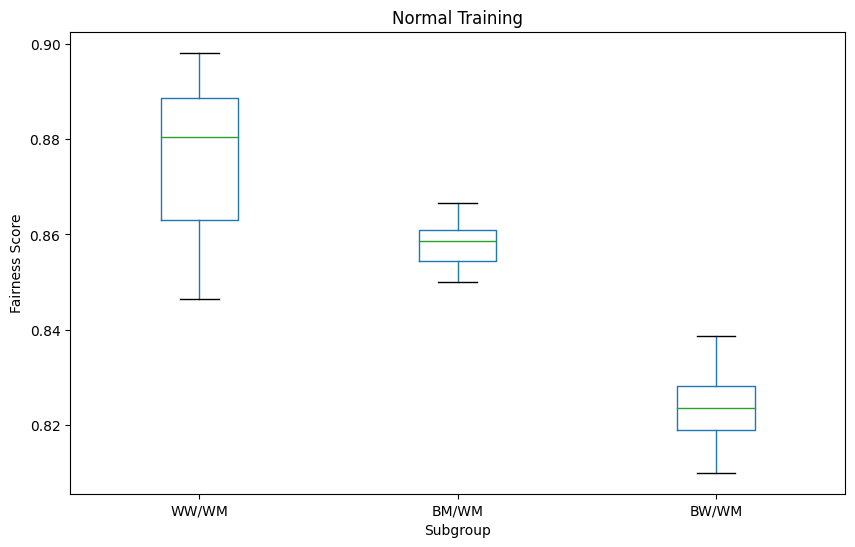

In [53]:

plt.figure(figsize=(10, 6))
normal_train_df.drop("State", axis=1).boxplot()
plt.title("Normal Training")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()

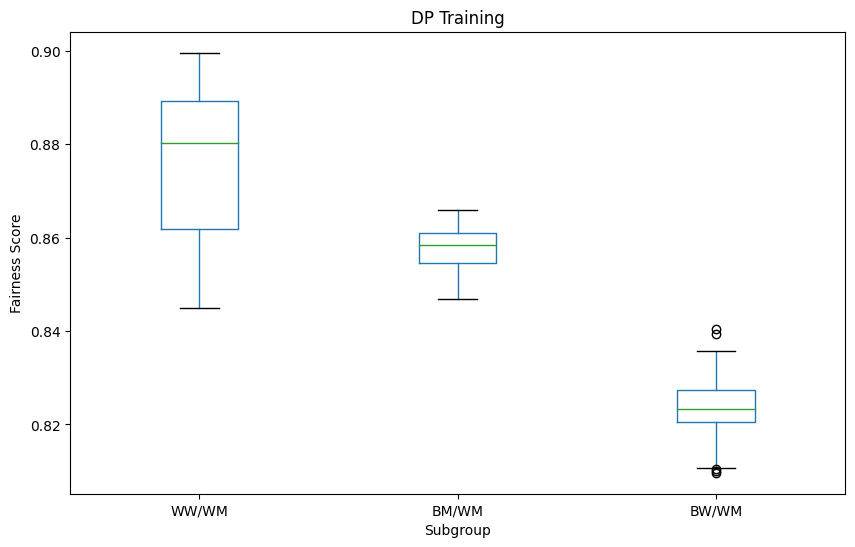

In [58]:
plt.figure(figsize=(10, 6))
dp_train_df.drop("State", axis=1).boxplot()
plt.title("DP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()

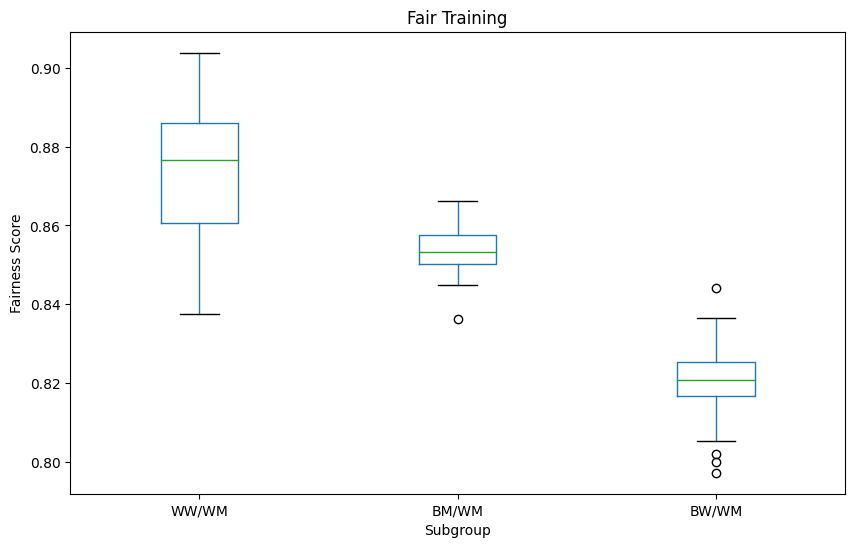

In [59]:
plt.figure(figsize=(10, 6))
fair_train_df.drop("State", axis=1).boxplot()
plt.title("Fair Training")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()

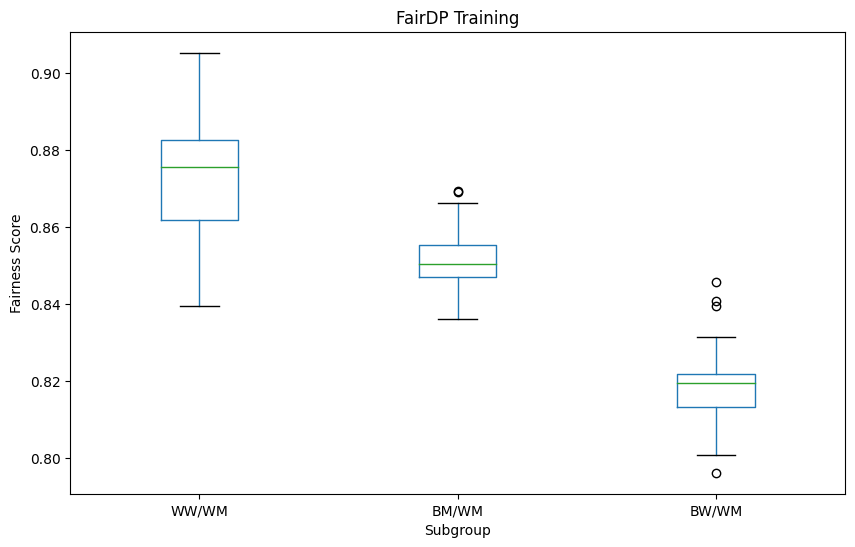

In [60]:
plt.figure(figsize=(10, 6))
fairDP_train_df.drop("State", axis=1).boxplot()
plt.title("FairDP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()

# Fair - Group Fairness

In [62]:
exp_3="tableak_FT_inversion_fair_group_loss"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_3}/50_clients_data/clients_fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.5148140428013075 : 0.7385064567203637 : 0.760853392847654 : 0.737820069591538 : 0.8254878787005275
WW
Total length of WW test data: 61620
0.48981765191131665 : 0.7461863031483285 : 0.8011392533821584 : 0.7402281520615639 : 0.7572348812614171
BM
Total length of BM test data: 6750
0.49826099833041004 : 0.7315555555555555 : 0.7909552376557453 : 0.7366750427758024 : 0.7239704329461457
BW
Total length of BW test data: 7730
0.5023491287773306 : 0.7186287192755498 : 0.7916067835584939 : 0.7313781023099117 : 0.7065161621344279
model_name AK
WM
Total length of WM test data: 68843
0.4859074373282908 : 0.7534825617709862 : 0.739664667351854 : 0.7539443421143407 : 0.694964111729267
WW
Total length of WW test data: 61620
0.5468564021129351 : 0.6880882830249919 : 0.7217718587145338 : 0.7360114936605662 : 0.5992212287280069
BM
Total length of BM test data: 6750
0.5749906689917307 : 0.6725925925925926 : 0.7171018945212494 : 0.7272897828063547 : 0.

In [64]:
final_result

{'AL': {'WM': 0.8254878787005275,
  'WW': 0.7572348812614171,
  'BM': 0.7239704329461457,
  'BW': 0.7065161621344279},
 'AK': {'WM': 0.694964111729267,
  'WW': 0.5992212287280069,
  'BM': 0.5915522703273495,
  'BW': 0.5669574140584915},
 'AZ': {'WM': 0.7919345075091522,
  'WW': 0.7128401115277377,
  'BM': 0.6889123548046463,
  'BW': 0.667863861809475},
 'AR': {'WM': 0.854371450808567,
  'WW': 0.7920632631477742,
  'BM': 0.7619852164730728,
  'BW': 0.7431161279288524},
 'CA': {'WM': 0.7183419330662132,
  'WW': 0.6254687049322181,
  'BM': 0.6122492080253432,
  'BW': 0.5878228151188644},
 'CO': {'WM': 0.7316595082298002,
  'WW': 0.6394337082972791,
  'BM': 0.6261879619852164,
  'BW': 0.6004788780571233},
 'CT': {'WM': 0.6913608716958289,
  'WW': 0.5931160465339871,
  'BM': 0.5875395987328406,
  'BW': 0.5616555498546263},
 'DE': {'WM': 0.7677207344844484,
  'WW': 0.6822661282568984,
  'BM': 0.6589229144667371,
  'BW': 0.6331452026680349},
 'FL': {'WM': 0.8036378311377591,
  'WW': 0.7266368

In [74]:

# filename = "inversion_group_fairDp_fairness.pickle"
filename = "inversion_subgroup_fair_group_loss.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_fair_group_loss.pickle


In [75]:
fair_train_group_loss = "inversion_subgroup_fair_group_loss.pickle"

In [76]:
with open(fair_train_group_loss, 'rb') as file:
    fair_train_loaded = pickle.load(file)

In [77]:
fair_train_df=subgroup_calculate_state_ratios(fair_train_loaded)

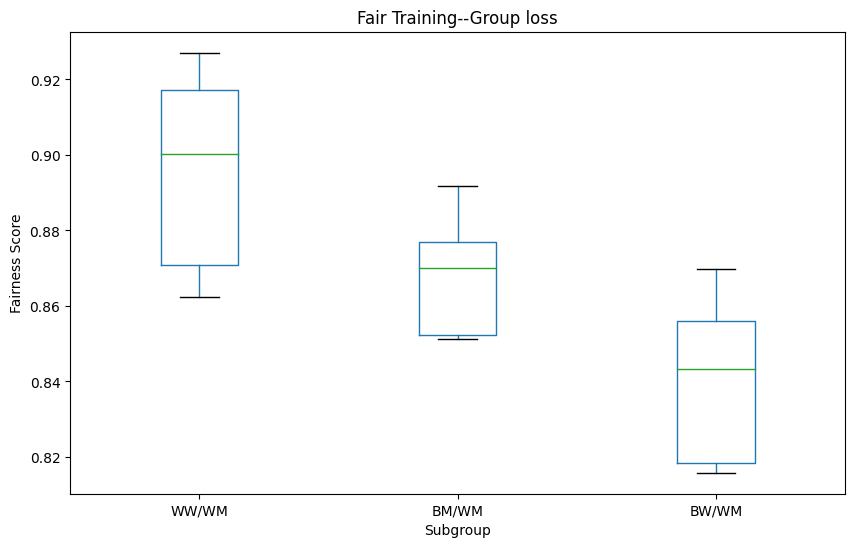

In [78]:
plt.figure(figsize=(10, 6))
fair_train_df.drop("State", axis=1).boxplot()
plt.title("Fair Training--Group loss")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()

# FairDP - Group Fairness

In [79]:
exp_4="tableak_FT_inversion_fairDP_group_loss"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_3}/50_clients_data/clients_fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
WM
Total length of WM test data: 68843
0.5149046636453127 : 0.7385064567203637 : 0.760853392847654 : 0.737820069591538 : 0.8254878787005275
WW
Total length of WW test data: 61620
0.48984696456885907 : 0.7461863031483285 : 0.8011392533821584 : 0.7402281520615639 : 0.7572348812614171
BM
Total length of BM test data: 6750
0.4983087869899533 : 0.7315555555555555 : 0.7909552376557453 : 0.7366750427758024 : 0.7239704329461457
BW
Total length of BW test data: 7730
0.5028319504142793 : 0.7186287192755498 : 0.7916067835584939 : 0.7313781023099117 : 0.7065161621344279
model_name AK
WM
Total length of WM test data: 68843
0.4858954713496355 : 0.7534825617709862 : 0.739664667351854 : 0.7539443421143407 : 0.694964111729267
WW
Total length of WW test data: 61620
0.5468577671552373 : 0.6880882830249919 : 0.7217718587145338 : 0.7360114936605662 : 0.5992212287280069
BM
Total length of BM test data: 6750
0.5749226424366377 : 0.6725925925925926 : 0.7171018945212494 : 0.7272897828063547 : 0.5

In [80]:
final_result

{'AL': {'WM': 0.8254878787005275,
  'WW': 0.7572348812614171,
  'BM': 0.7239704329461457,
  'BW': 0.7065161621344279},
 'AK': {'WM': 0.694964111729267,
  'WW': 0.5992212287280069,
  'BM': 0.5915522703273495,
  'BW': 0.5669574140584915},
 'AZ': {'WM': 0.7919345075091522,
  'WW': 0.7128401115277377,
  'BM': 0.6889123548046463,
  'BW': 0.667863861809475},
 'AR': {'WM': 0.854371450808567,
  'WW': 0.7920632631477742,
  'BM': 0.7619852164730728,
  'BW': 0.7431161279288524},
 'CA': {'WM': 0.7183419330662132,
  'WW': 0.6254687049322181,
  'BM': 0.6122492080253432,
  'BW': 0.5878228151188644},
 'CO': {'WM': 0.7316595082298002,
  'WW': 0.6394337082972791,
  'BM': 0.6261879619852164,
  'BW': 0.6004788780571233},
 'CT': {'WM': 0.6913608716958289,
  'WW': 0.5931160465339871,
  'BM': 0.5875395987328406,
  'BW': 0.5616555498546263},
 'DE': {'WM': 0.7677207344844484,
  'WW': 0.6822661282568984,
  'BM': 0.6589229144667371,
  'BW': 0.6331452026680349},
 'FL': {'WM': 0.8036378311377591,
  'WW': 0.7266368

In [81]:
filename = "inversion_subgroup_fairDp_group_loss.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_subgroup_fairDp_group_loss.pickle


In [82]:
fairdp_train_group_loss = "inversion_subgroup_fairDp_group_loss.pickle"

In [83]:
with open(fairdp_train_group_loss, 'rb') as file:
    fairdp_train_loaded = pickle.load(file)

In [84]:
fairdp_train_df=subgroup_calculate_state_ratios(fairdp_train_loaded)

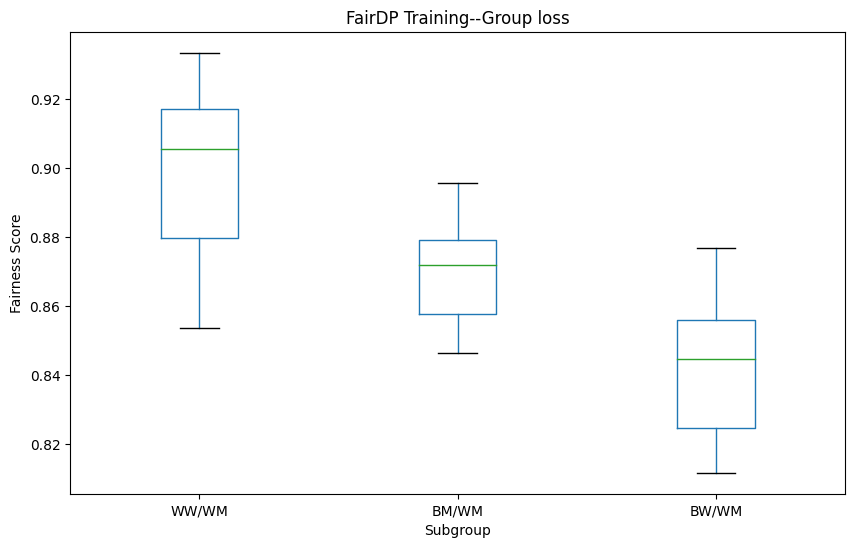

In [85]:
plt.figure(figsize=(10, 6))
fairdp_train_df.drop("State", axis=1).boxplot()
plt.title("FairDP Training--Group loss")
plt.ylabel("Fairness Score")
plt.xlabel("Subgroup")
plt.grid(False)
plt.show()